# Task 1: Web Scraping and Analysis

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from textblob import TextBlob
#to be able to manipulate the OS directories
import os
#to be able to use regular expressions
import re

import nltk

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#to be able to deal with emojis
#!pip install emoji ##REMOVE THE COMMENT AT THE BEGINING TO INSTALL EMOJI IF YOU DONT HAVE IS IN YOUR SISTEM
import emoji

#WORDCLOUD
import matplotlib.pyplot as plt
from PIL import Image
#!pip install wordcloud ##REMOVE THE COMMENT AT THE BEGINING TO INSTALL WORDCLOUD IF YOU DONT HAVE IS IN YOUR SISTEM
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 20
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head(20)

,reviews
0,✅ Trip Verified | Absolutely terrible experie...
1,✅ Trip Verified | BA overbook every flight to ...
2,✅ Trip Verified | \r\nThe flights were all on...
3,Not Verified | Only the second time flying BA ...
4,✅ Trip Verified | I wasn't going to bother rev...
5,✅ Trip Verified | I booked business class tic...
6,✅ Trip Verified | I will never travel with Br...
7,✅ Trip Verified | I am already in Portugal so...
8,✅ Trip Verified | Terrible. Avoid this airlin...
9,✅ Trip Verified | Despite being a gold member...


In [4]:
#to make sure the data folder exists, if no, create it and save the data inside
outname = 'BA_reviews.csv'
outdir = './data'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)  
df.to_csv(fullname)

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
#data preview
df.head(20)

,reviews
0,✅ Trip Verified | Absolutely terrible experie...
1,✅ Trip Verified | BA overbook every flight to ...
2,✅ Trip Verified | \r\nThe flights were all on...
3,Not Verified | Only the second time flying BA ...
4,✅ Trip Verified | I wasn't going to bother rev...
5,✅ Trip Verified | I booked business class tic...
6,✅ Trip Verified | I will never travel with Br...
7,✅ Trip Verified | I am already in Portugal so...
8,✅ Trip Verified | Terrible. Avoid this airlin...
9,✅ Trip Verified | Despite being a gold member...


#### DATA CLEARNING

In [6]:
# extract 'Trip Verified' or 'Not Verified' from the 'reviews' column
pattern = r'Trip Verified|Not Verified'

# define a function to extract the trip status
def extract_trip_status(text):
    match = re.findall(pattern, text)
    if match:
        return match[0]
    else:
        return ''

# apply the function to the 'reviews' column and create a new column 'trip_status'
df['trip_status'] = df['reviews'].apply(extract_trip_status)

# show only the lines where the trip_status is 'Trip Verified'
#Using .copy() to avoid the SettingWithCopyWarning.
verified_reviews = df[df['trip_status'] == 'Trip Verified'].copy()
#preview
print(verified_reviews)

                                                reviews    trip_status
0     ✅ Trip Verified |  Absolutely terrible experie...  Trip Verified
1     ✅ Trip Verified | BA overbook every flight to ...  Trip Verified
2     ✅ Trip Verified |  \r\nThe flights were all on...  Trip Verified
4     ✅ Trip Verified | I wasn't going to bother rev...  Trip Verified
5     ✅ Trip Verified |  I booked business class tic...  Trip Verified
...                                                 ...            ...
1226  ✅ Trip Verified | After 3 hour delay at airpor...  Trip Verified
1227  ✅ Trip Verified | Flew British Airways from Ma...  Trip Verified
1228  ✅ Trip Verified |  Tel Aviv to London. We arri...  Trip Verified
1229  ✅ Trip Verified |  London to Tel Aviv. Arrived...  Trip Verified
1230  ✅ Trip Verified |  Kuala Lumpur to Madrid via ...  Trip Verified

[1039 rows x 2 columns]


In [7]:
#Remove common 'English' words, which are of little value in text analysis.
stopwords = set(STOPWORDS)
#MORE STOPWORDS ARE NECESSARY TO MAKE SURE WE HAVE A MORE PRECISE INSIGTH FROM THE TOPIC MODELLING AND WORDCLOUDS
stopwords.update(['class','due','aircraft','said','review','told','us','airways','london','s','’t','’','t','put', 'use', 'airway', 'british', 'trying', 'one', 'destination', 'get', 
                  'time', 'type', 'trip', 'verified', 'life', 'check_mark_button', 'ba', 'hour', 'email', 'received', 
                  'generic', 'maybe', 'ask', 'flight','d', 'll', 'm', 're', 's', 't', 've', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 
                   'haven', 'isn', 'let', 'mustn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'the', 'a', 'an',
                  'and', 'of', 'to', 'in', 'that', 'it', 'with', 'for', 'on', 'at', 'by', 'this', 'we', 'you', 'not', 
                  'but', 'as', 'or', 'if', 'from', 'so', 'they', 'he', 'she', 'his', 'her', 'its', 'their', 'our', 'my', 
                  'me', 'I', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does',
                  'did', 'will', 'would', 'should', 'could', 'york', 'can','year', 'may', 'might', 'must', 'shall', 'should', "'d", "'ll", "'m", "'re", "'s", "'t", "'ve"])

#This function takes a list of texts as input and removes stopwords from each text
def remove_stopwords(texts):
    # For each text in the input list, the function applies simple_preprocess() to tokenize the text into a list of words,
    # and removes stopwords from this list of words using a list called 'stopwords'
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]

#Get the 'reviews' column from the dataframe df and convert it to a list
data = verified_reviews.reviews.values.tolist()

#Apply the function remove_stopwords() to the list 'data' to remove stopwords from each text in the list
data_words = remove_stopwords(data)

#Print the first 30 words from the first text in the list 'data_words'
print(data_words[:1][0][:30])


['absolutely', 'terrible', 'experience', 'app', 'check', 'online', 'repeatedly', 'asked', 'covid', 'documents', 'accept', 'even', 'provided', 'fly', 'back', 'usa', 'citizen', 'app', 'caused', 'repeated', 'errors', 'went', 'customer', 'service', 'check', 'seat', 'already', 'given', 'away', 'another']


In [8]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
  
# cleaning master function
def clean_reviews(reviews, bigrams=False):
  
    reviews = reviews.lower() # lower case
    reviews= re.sub('['+punctuation + ']+', ' ', reviews) # strip punctuation
    reviews = re.sub('\s+', ' ', reviews) #remove double spacing
    reviews = re.sub('([0-9]+)', '', reviews) # remove numbers
    # remove emojis
    reviews = emoji.demojize(reviews)
    reviews = reviews.replace(':', ' ')

    # tokenize the text by splitting it into words and store them in a list
    reviews_token_list = [word for word in reviews.split(' ')
                            if word not in stopwords] # remove stopwords
   
    # if the bigrams parameter is True, create bigrams by combining adjacent words in the token list
    if bigrams:
        reviews_token_list = reviews_token_list+[reviews_token_list[i]+'_'+reviews_token_list[i+1]
                                            for i in range(len(reviews_token_list)-1)]
    # join the words back into a single string separated by spaces and return it   
    reviews = ' '.join(reviews_token_list)
    return reviews

In [9]:
verified_reviews.loc[:, 'clean_reviews'] = verified_reviews.reviews.apply(clean_reviews)


"""
#THIS CODE IF TO SPELLING CHECK, ITS COMMENTED DUE TO PERFORMANCE ISSUES :)
# define a function to correct the spelling
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# apply the function to the 'text' column
verified_reviews['clean_reviews'] = verified_reviews['clean_reviews'].apply(correct_spelling)

# print the corrected dataframe

"""
verified_reviews.head(20)

,reviews,trip_status,clean_reviews
0,✅ Trip Verified | Absolutely terrible experie...,Trip Verified,absolutely terrible experience app check onl...
1,✅ Trip Verified | BA overbook every flight to ...,Trip Verified,overbook every maximise income regard custom...
2,✅ Trip Verified | \r\nThe flights were all on...,Trip Verified,flights except belfast never staff efficient...
4,✅ Trip Verified | I wasn't going to bother rev...,Trip Verified,going bother reviewing seem perpetual downer...
5,✅ Trip Verified | I booked business class tic...,Trip Verified,booked business tickets fiancé reschedule un...
6,✅ Trip Verified | I will never travel with Br...,Trip Verified,never travel spent business seat attend fu...
7,✅ Trip Verified | I am already in Portugal so...,Trip Verified,already portugal contacted today cancelled r...
8,✅ Trip Verified | Terrible. Avoid this airlin...,Trip Verified,terrible avoid airline it’s now becoming reg...
9,✅ Trip Verified | Despite being a gold member...,Trip Verified,despite gold member staff heathrow literally...
13,✅ Trip Verified | Had the worst experience. Th...,Trip Verified,worst experience toronto got delayed missed ...


#### TOPIC MODELLING

In [10]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+', stop_words=stopwords)

# apply transformation
tf = vectorizer.fit_transform(verified_reviews['clean_reviews']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

In [11]:
#assigns the number of topics to be modeled as 10.
number_of_topics = 5
#creates an instance of the LatentDirichletAllocation model with number_of_topics topics and a random state of 0.
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
#fits the model to the data represented by tf, which is typically a term frequency matrix.
model.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [12]:
#Define a function to display topics based on a fitted model, feature names and the number of top words to display
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        # Create a dictionary for each topic with its top words and corresponding weights
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    # Convert the dictionary to a Pandas DataFrame and return it
    return pd.DataFrame(topic_dict)

In [13]:
#set the number of top words to be displayed for each topic
no_top_words = 5
#call the function display_topics to display the topics generated by the LDA model with their respective top words and weights
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,check,234.5,good,417.2,hours,142.3,seat,266.5,staff,123.4
1,business,174.8,crew,410.6,day,122.7,economy,219.9,service,122.9
2,seats,157.3,service,364.9,service,119.6,seats,180.4,customer,106.1
3,seat,153.4,food,339.1,customer,113.3,premium,136.0,call,101.4
4,boarding,141.0,cabin,304.5,booked,108.6,food,120.5,airport,98.4


#### SENTIMENT ANALYSIS

                          reviews  trip_status  clean_reviews  sentiment
sentiment_human_language                                                
negative                      327          327            327        327
neutral                        13           13             13         13
positive                      699          699            699        699


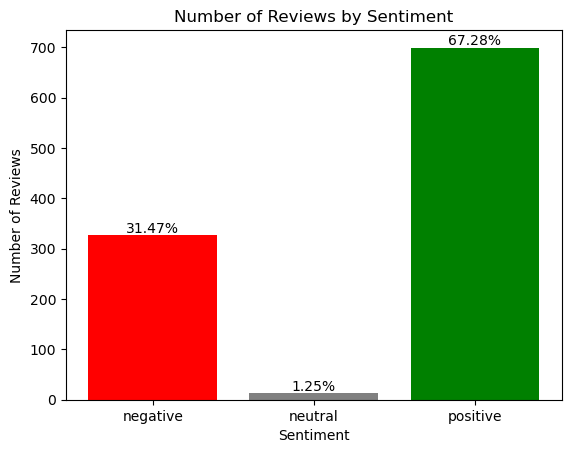

In [14]:
# Define a function to get the sentiment and translate it to human language
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return sentiment, 'positive'
    elif sentiment < 0:
        return sentiment, 'negative'
    else:
        return sentiment, 'neutral'

# Apply the function to the 'text' column and create new columns 'sentiment' and 'sentiment_translation'
verified_reviews[['sentiment', 'sentiment_human_language']] = verified_reviews.clean_reviews.apply(lambda x: pd.Series(get_sentiment(x)))

# group the dataframe by 'sentiment_human_language' and count the number of reviews
count_df = verified_reviews.groupby('sentiment_human_language').count()

print(count_df)



# Set the color for each bar
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

# Calculate the percentage for each sentiment
total_reviews = count_df['reviews'].sum()
percentages = [count / total_reviews * 100 for count in count_df['reviews']]

# Plot the chart
plt.bar(count_df.index, count_df['reviews'], color=[colors[s] for s in count_df.index])

# Add percentages as labels on top of each bar
for i, count in enumerate(count_df['reviews']):
    plt.text(i, count+5, f"{percentages[i]:.2f}%", ha='center', color='black')

# Set the title and axis labels
plt.title('Number of Reviews by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Display the chart
plt.show()

#### WORDCLOUDS

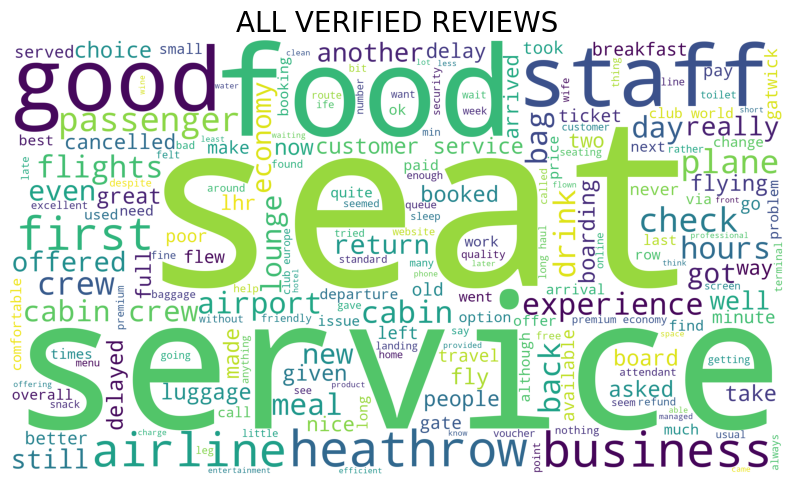

In [15]:
#geeting the cleared data
cleaned_reviews = verified_reviews['clean_reviews']
# concatenar as palavras
all_reviews = " ".join(s for s in cleaned_reviews)

# generate the wordcloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=2560, height=1440).generate(all_reviews)
# plot the image
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.title('ALL VERIFIED REVIEWS', fontsize=20) # set the title using matplotlib
plt.imshow(wordcloud);
wordcloud.to_file("ba_reviews_wordcloud.png")

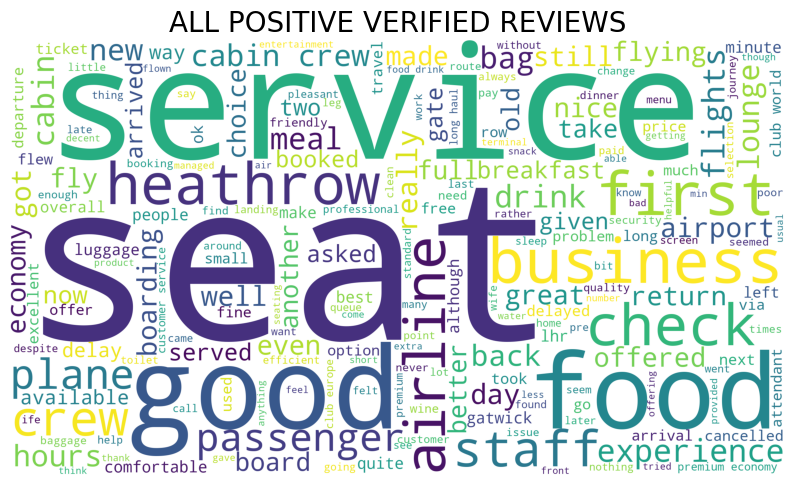

In [16]:
#Wordcloud of only positive reviews
negative_reviews = verified_reviews[verified_reviews['sentiment_human_language'] == 'positive']
#print(negative_reviews)


#geeting the cleared data
cleaned_reviews = negative_reviews['clean_reviews']
# concatenar as palavras
all_positive = " ".join(s for s in cleaned_reviews)

# generate the wordcloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=2560, height=1440, colormap='viridis').generate(all_positive)
# plot the image
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.title('ALL POSITIVE VERIFIED REVIEWS', fontsize=20) # set the title using matplotlib
plt.imshow(wordcloud);
wordcloud.to_file("ba_positive_reviews_wordcloud.png")

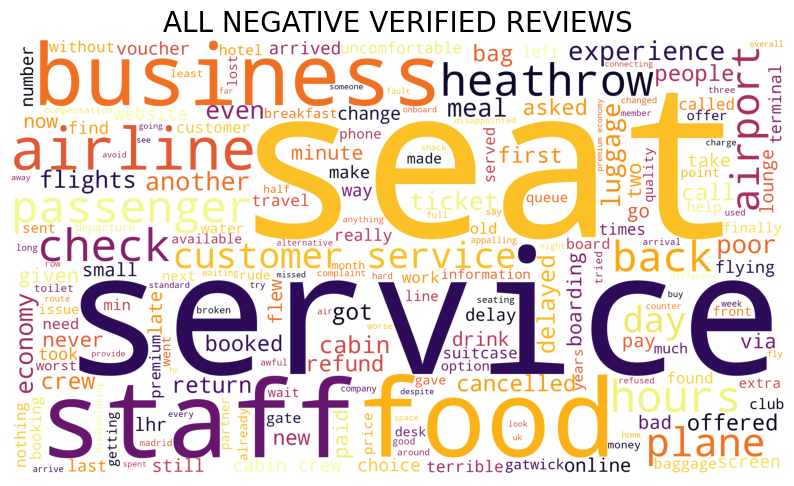

In [17]:
#Wordcloud of only negative reviews
negative_reviews = verified_reviews[verified_reviews['sentiment_human_language'] == 'negative']
#print(negative_reviews)


#geeting the cleared data
cleaned_reviews = negative_reviews['clean_reviews']
# concatenar as palavras
all_negative = " ".join(s for s in cleaned_reviews)

# generate the wordcloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=2560, height=1440, colormap='inferno').generate(all_negative)
# plot the image
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.title('ALL NEGATIVE VERIFIED REVIEWS', fontsize=20) # set the title using matplotlib
plt.imshow(wordcloud);
wordcloud.to_file("ba_negative_reviews_wordcloud.png")